In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_path():
    xs = [x[perm[i]] for i in range(n)]
    ys = [y[perm[i]] for i in range(n)]
    xs.append(x[perm[0]])
    ys.append(y[perm[0]])
    plt.plot(xs, ys, marker='s', markerfacecolor='red')
    plt.show()

In [24]:
def generate_numbers(left, right, tak):
    return [np.random.uniform(left, right) for _ in range(tak)]

def generate_uniform(tak):
    return generate_numbers(0, 1, tak), generate_numbers(0, 1, tak)

def euclid_dist(x1, x2, y1, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def generate_clusters(k):
    first = []
    second = []
    intervals = []
    for i in range(2):
        for j in range(2):
            intervals.append((i*10, i*10 + 2, j*10, j*10 + 2))

    for a, b, c, d in intervals:
        first += generate_numbers(a, b, k)
        second += generate_numbers(c, d, k)
    return first, second

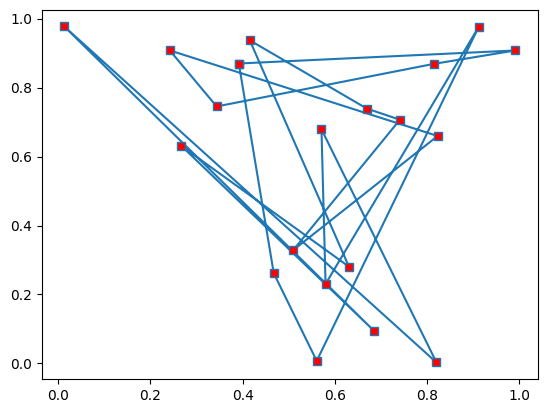

In [25]:
n = 20
x, y = generate_uniform(n)
perm = [i for i in range(n)]
dist_matrix = [[euclid_dist(x[i], x[j], y[i], y[j]) for i in range(n)] for j in range(n)]
plot_path()

In [26]:
def calculate_energy(new_perm):
    energy = 0
    for i in range(1, n):
        energy += dist_matrix[new_perm[i]][new_perm[i-1]]
    energy += dist_matrix[new_perm[-1]][new_perm[0]]
    return energy

def generate_neighbor(p):
    a = np.random.randint(0, n - 1)
    b = np.random.randint(a + 1, n)
    new_p = p[:]
    new_p[a], new_p[b] = new_p[b], new_p[a]
    return new_p

def generate_neighbor2(p):
    a = np.random.randint(0, n - 1)
    b = np.random.randint(a + 1, n)
    new_p = p[:]
    m = (b - a) // 2
    for i in range(a, a + m + 1):
        new_p[i], new_p[b + a - i] = new_p[b + a - i], new_p[i]
    return new_p

def generate_neighbor3(p):
    a = np.random.randint(0, n - 1)
    new_p = p[:]
    new_p[a], new_p[a + 1] = new_p[a + 1], new_p[a]
    return new_p

def calc_value(points):
    suma = 0
    for i in range(1, len(points)):
        suma += euclid_dist(points[i][0], points[i-1][0], points[i][1], points[i-1][1])
    suma += euclid_dist(points[-1][0], points[0][0], points[-1][1], points[0][1])
    return suma

In [27]:
for _ in range(30):
    a = np.random.randint(0, n - 1)
    b = np.random.randint(a + 1, n)
    perm[a], perm[b] = perm[b], perm[a]

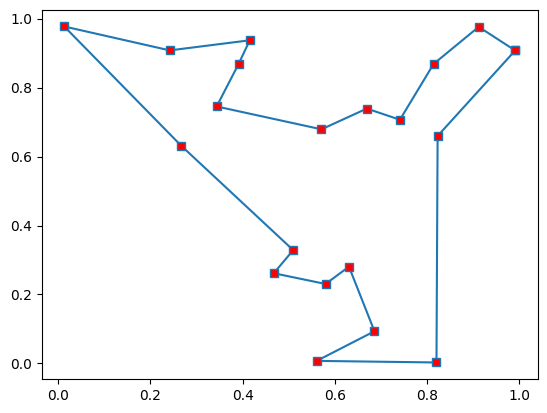

4.125831687154109


In [28]:
def plotting(points):
    xs = [a for a, b in points] + [points[0][0]]
    ys = [b for a, b in points] + [points[0][1]]
    plt.plot(xs, ys, marker='s', markerfacecolor='red')
    plt.show()

def best_heuristic(x, y):
    points2 = [(a, b) for a, b in zip(x, y)]
    points = [points2[-1]]
    points2.pop()
    last = points[0]
    for _ in range(n - 1):
        best = 0
        dist = euclid_dist(last[0], points2[0][0], last[1], points2[0][1])
        for i in range(1, len(points2)):
            d = euclid_dist(last[0], points2[i][0], last[1], points2[i][1])
            if d < dist:
                dist = d
                best = i
        new = points2.pop(best)
        points.append(new)
        last = new
    plotting(points)
    print(calc_value(points))


best_heuristic(x, y)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


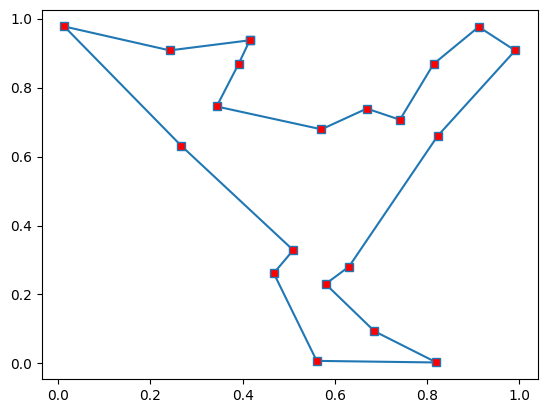

4.0363046585814795


In [29]:
def pop_count(number):
    count = 0
    while number:
        count += number % 2
        number //= 2
    return count


def to_bin(number):
    return to_bin(number // 2) + str(number%2) if number else ""

def optimal_salesman(x, y):
    points = [(a, b) for a, b in zip(x, y)]
    matrix = [[euclid_dist(a, c, b, d) for a, b in points] for c, d in points]
    m = len(points)
    al = 1<<m
    dp = [[float("inf") for _ in range(m)] for _ in range(al)]
    parent = [[None for _ in range(m)] for _ in range(al)]
    dp[1][0] = 0
    for i in range(2, m + 1):
        print(i)
        for mask in range(al):
            if pop_count(mask) != i or not 1&mask:
                continue
            for city in range(1, m):
                bit_number = 1<<city
                if not bit_number & mask:
                    continue
                for last_city in range(m):
                    bit_number_last = 1<<last_city
                    if city == last_city or not bit_number_last&mask:
                        continue
                    if dp[mask][city] > dp[mask^bit_number][last_city] + matrix[city][last_city]:
                        dp[mask][city] = dp[mask^bit_number][last_city] + matrix[city][last_city]
                        parent[mask][city] = last_city

    ans = float("inf")
    cur_city = 0
    for city in range(1, m):
        if ans > dp[al - 1][city] + matrix[0][city]:
            ans = dp[al - 1][city] + matrix[0][city]
            cur_city = city

    ans_points = [points[cur_city]]
    mask = al - 1
    while cur_city:
        next_city = parent[mask][cur_city]
        ans_points.append(points[next_city])
        mask ^= 1<<cur_city
        cur_city = next_city
    plotting(ans_points)
    print(ans)

optimal_salesman(x, y)

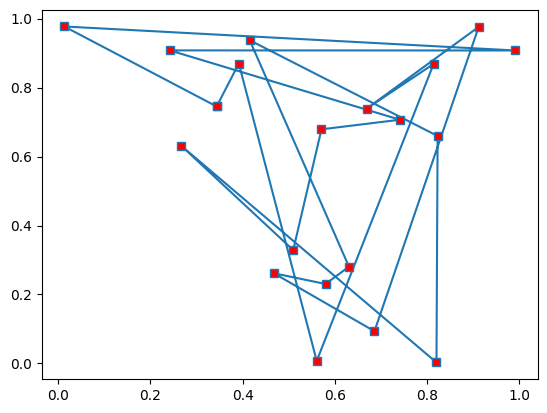

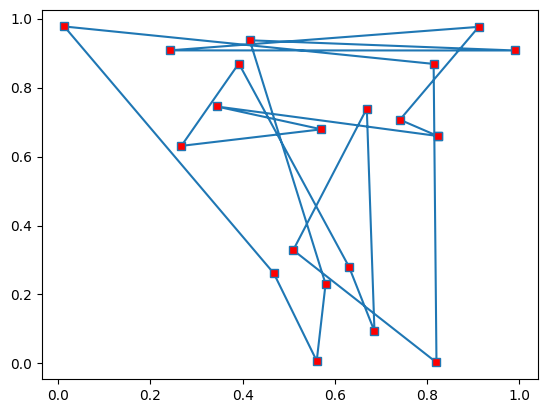

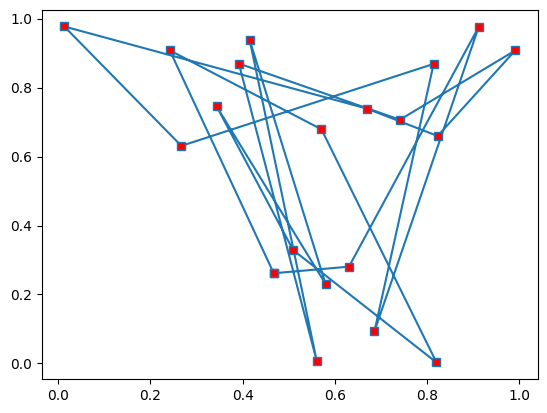

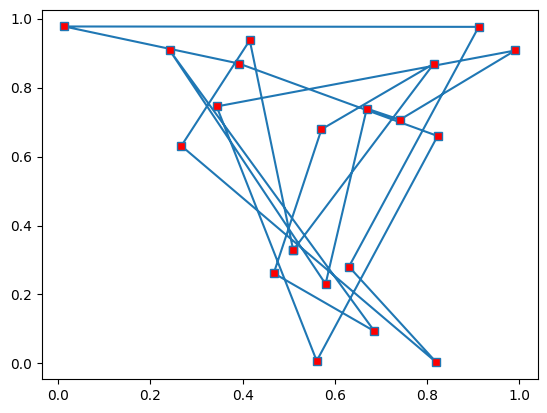

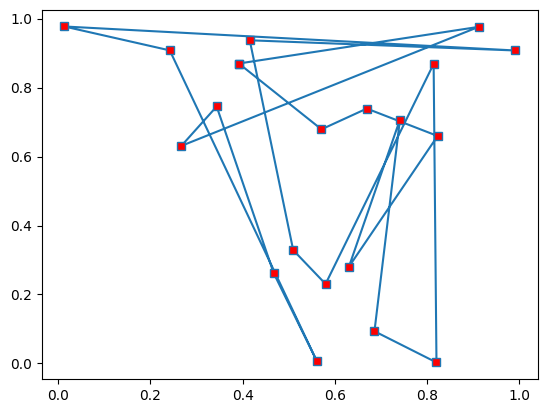

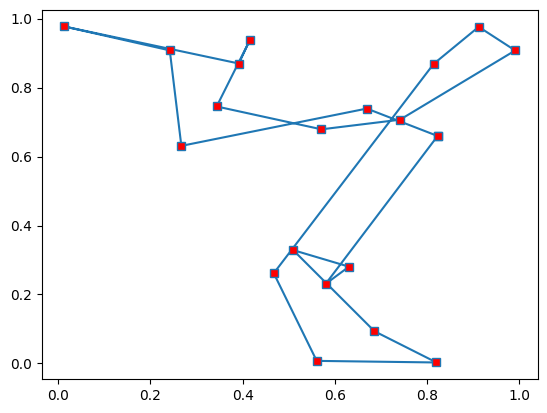

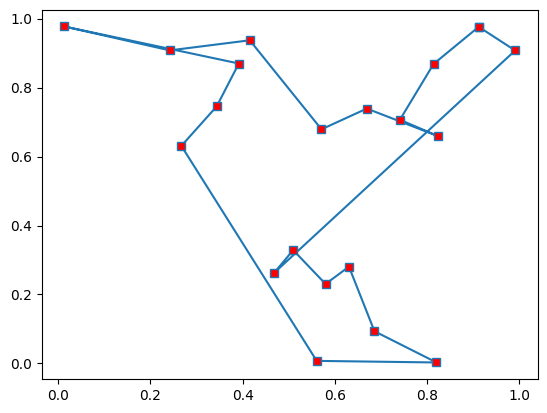

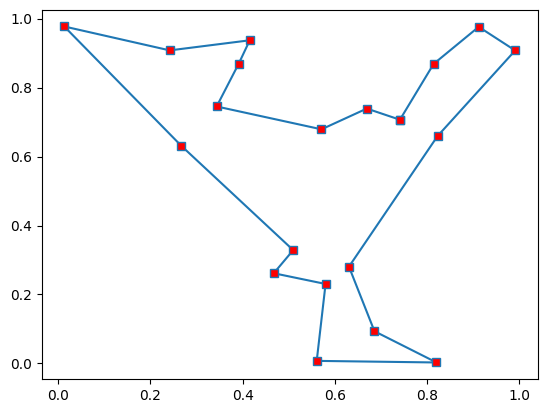

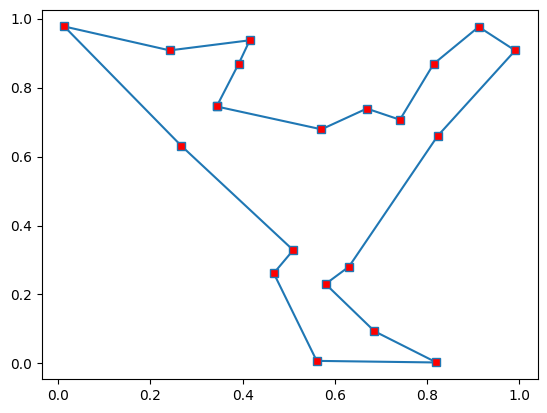

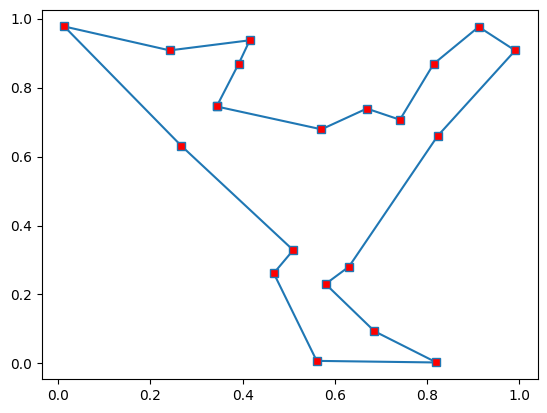

4.0363046585814795


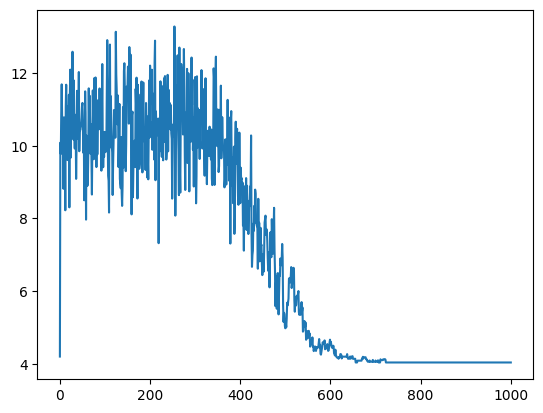

In [34]:
alpha = 0.99
T0 = 10
T = T0
cur_energy = calculate_energy(perm)
energy_states = [cur_energy]
steps = 1000
for i in range(steps):
    for _ in range(20):
        new_state = generate_neighbor2(perm)
        next_energy = calculate_energy(new_state)
        if next_energy < cur_energy:
            perm = new_state
            cur_energy = next_energy
        else:
            p1 = np.exp((cur_energy - next_energy) / T)
            if p1 > np.random.uniform(0, 0.1):
                perm = new_state
                cur_energy = next_energy
    T = T *alpha
    energy_states.append(cur_energy)
    if i % 100 == 0:
        plot_path()
print(calculate_energy(perm))
plt.plot([i for i in range(steps + 1)], energy_states)